# Twitter Bot Detector
In this notebook, we are using a dataset from [Kaggle](https://www.kaggle.com/davidmartngutirrez/twitter-bots-accounts) and [Botometer](https://botometer.osome.iu.edu/bot-repository/datasets.html), containing in total 26K twitter user ids. Thanks to the Tweepy Python library we are retrieving users' information, which we considered useful in order to determine the type of an account.We have numerical, categorical and also textual features. So we train 3 models, one for the numerical/categorical features, another for the textual features and one more for the combination of the two types of features.
We also used different classifiers and different evaluation metrics, in order to make comparisons between the results.

### Install Dependencies

In [0]:
!sudo pip install --upgrade pip
!sudo pip install pyspark --upgrade
!pip install nltk
!pip install stopwords
!pip install mlflow
!pip install tweepy

Requirement already satisfied: pip in /usr/local/lib/python3.8/site-packages (21.1.1)
 WARNING: Running pip as root will break packages and permissions. You should install packages reliably by using venv: https://pip.pypa.io/warnings/venv 
Requirement already satisfied: pyspark in /usr/local/lib/python3.8/site-packages (3.1.1)
Requirement already satisfied: py4j==0.10.9 in /usr/local/lib/python3.8/site-packages (from pyspark) (0.10.9)
 WARNING: Running pip as root will break packages and permissions. You should install packages reliably by using venv: https://pip.pypa.io/warnings/venv 
Requirement already satisfied: nltk in /databricks/python3/lib/python3.8/site-packages (3.6.2)
Requirement already satisfied: tqdm in /databricks/python3/lib/python3.8/site-packages (from nltk) (4.60.0)
Requirement already satisfied: click in /databricks/python3/lib/python3.8/site-packages (from nltk) (8.0.0)
Requirement already satisfied: regex in /databricks/python3/lib/python3.8/site-packages (from nltk) (2021.4.4)
Requirement already satisfied: joblib in /databricks/python3/lib/python3.8/site-packages (from nltk) (0.17.0)
 WARNING: You are using pip version 20.2.4; however, version 21.1.1 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command. 
Requirement already satisfied: stopwords in /databricks/python3/lib/python3.8/site-packages (1.0.0)
 WARNING: You are using pip version 20.2.4; however, version 21.1.1 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command. 
Requirement already satisfied: mlflow in /databricks/python3/lib/python3.8/site-packages (1.17.0)
Requirement already satisfied: pandas in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.1.3)
Requirement already satisfied: requests>=2.17.3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.24.0)
Requirement already satisfied: pytz in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2020.5)
Requirement already satisfied: gunicorn; platform_system != "Windows" in /databricks/python3/lib/python3.8/site-packages (from mlflow) (20.1.0)
Requirement already satisfied: sqlparse>=0.3.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.4.1)
Requirement already satisfied: cloudpickle in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.6.0)
Requirement already satisfied: sqlalchemy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.4.15)
Requirement already satisfied: querystring-parser in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.2.4)
Requirement already satisfied: Flask in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.0.0)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.19.2)
Requirement already satisfied: alembic<=1.4.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.4.1)
Requirement already satisfied: pyyaml in /databricks/python3/lib/python3.8/site-packages (from mlflow) (5.4.1)
Requirement already satisfied: click>=7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (8.0.0)
Requirement already satisfied: prometheus-flask-exporter in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.18.2)
Requirement already satisfied: docker>=4.0.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (5.0.0)
Requirement already satisfied: gitpython>=2.1.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.1.17)
Requirement already satisfied: databricks-cli>=0.8.7 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.14.3)
Requirement already satisfied: protobuf>=3.6.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.17.0)
Requirement already satisfied: entrypoints in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.3

### Import Python Packages

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import udf
from pyspark.sql.session import SparkSession
from pyspark import SparkContext, SparkConf, SparkFiles
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import FMClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.feature import StopWordsRemover, Word2Vec, RegexTokenizer, Tokenizer, MinMaxScaler
from pyspark.sql.functions import udf, col, lower, trim, regexp_replace

import datetime
import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import re
from IPython.display import HTML
now = datetime.datetime.now()
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  
lancaster = LancasterStemmer()
RANDOM_SEED = 42 # for reproducibility

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Package stopwords is already up-to-date!

### Check everything is ok

In [0]:
spark
sc._conf.getAll()

Out[77]: [('spark.files.useFetchCache', 'false'),
 ('spark.databricks.preemption.enabled', 'true'),
 ('spark.driver.tempDirectory', '/local_disk0/tmp'),
 ('spark.hadoop.fs.adl.impl.disable.cache', 'true'),
 ('spark.hadoop.parquet.block.size.row.check.max', '10'),
 ('spark.hadoop.fs.s3a.connection.maximum', '200'),
 ('spark.databricks.clusterUsageTags.clusterName', 'ghggvghasdd'),
 ('spark.databricks.clusterUsageTags.numPerClusterInitScriptsV2', '0'),
 ('spark.executor.extraJavaOptions',
 '-Djava.io.tmpdir=/local_disk0/tmp -XX:ReservedCodeCacheSize=512m -XX:+UseCodeCacheFlushing -Djava.security.properties=/databricks/spark/dbconf/java/extra.security -XX:-UseContainerSupport -XX:+PrintFlagsFinal -XX:+PrintGCDateStamps -verbose:gc -XX:+PrintGCDetails -Xss4m -Djava.library.path=/usr/java/packages/lib/amd64:/usr/lib64:/lib64:/lib:/usr/lib:/usr/lib/x86_64-linux-gnu/jni:/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu:/usr/lib/jni -Djavax.xml.datatype.DatatypeFactory=com.sun.org.apache.xerces.internal.jaxp.datatype.DatatypeFactoryImpl -Djavax.xml.parsers.DocumentBuilderFactory=com.sun.org.apache.xerces.internal.jaxp.DocumentBuilderFactoryImpl -Djavax.xml.parsers.SAXParserFactory=com.sun.org.apache.xerces.internal.jaxp.SAXParserFactoryImpl -Djavax.xml.validation.SchemaFactory:http://www.w3.org/2001/XMLSchema=com.sun.org.apache.xerces.internal.jaxp.validation.XMLSchemaFactory -Dorg.xml.sax.driver=com.sun.org.apache.xerces.internal.parsers.SAXParser -Dorg.w3c.dom.DOMImplementationSourceList=com.sun.org.apache.xerces.internal.dom.DOMXSImplementationSourceImpl -Djavax.net.ssl.sessionCacheSize=10000 -Dscala.reflect.runtime.disable.typetag.cache=true -Ddatabricks.serviceName=spark-executor-1'),
 ('spark.hadoop.fs.s3a.fast.upload.active.blocks', '32'),
 ('spark.shuffle.reduceLocality.enabled', 'false'),
 ('spark.sql.streaming.checkpointFileManagerClass',
 'com.databricks.spark.sql.streaming.DatabricksCheckpointFileManager'),
 ('spark.databricks.service.dbutils.repl.backend',
 'com.databricks.dbconnect.ReplDBUtils'),
 ('spark.databricks.clusterUsageTags.driverNodeType', 'dev-tier-node'),
 ('spark.hadoop.spark.sql.sources.outputCommitterClass',
 'com.databricks.backend.daemon.data.client.MapReduceDirectOutputCommitter'),
 ('spark.hadoop.fs.AbstractFileSystem.gs.impl',
 'shaded.databricks.V2_1_4.com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS'),
 ('spark.databricks.clusterUsageTags.instanceBootstrapType', 'ssh'),
 ('spark.streaming.driver.writeAheadLog.allowBatching', 'true'),
 ('spark.databricks.clusterSource', 'UI'),
 ('spark.hadoop.hive.server2.transport.mode', 'http'),
 ('spark.databricks.sparkContextId', '8975182276476593751'),
 ('spark.hadoop.hive.server2.thrift.http.cookie.auth.enabled', 'false'),
 ('spark.executor.memory', '8278m'),
 ('spark.databricks.driverNodeTypeId', 'dev-tier-node'),
 ('spark.sql.parquet.compression.codec', 'snappy'),
 ('spark.r.sql.derby.temp.dir', '/tmp/Rtmp3MYlWX'),
 ('spark.databricks.clusterUsageTags.driverPublicDns',
 'ec2-54-202-93-120.us-west-2.compute.amazonaws.com'),
 ('spark.hadoop.fs.cpfs-adl.impl.disable.cache', 'true'),
 ('spark.databricks.clusterUsageTags.hailEnabled', 'false'),
 ('spark.databricks.clusterUsageTags.clusterLogDeliveryEnabled', 'false'),
 ('spark.databricks.clusterUsageTags.containerType', 'LXC'),
 ('spark.eventLog.enabled', 'false'),
 ('spark.databricks.clusterUsageTags.isIMv2Enabled', 'false'),
 ('spark.databricks.cloudfetch.hasRegionSupport', 'true'),
 ('spark.hadoop.databricks.s3.create.deleteUnnecessaryFakeDirectories',
 'false'),
 ('spark.hadoop.fs.wasb.impl',
 'shaded.databricks.org.apache.hadoop.fs.azure.NativeAzureFileSystem'),
 ('spark.executor.tempDirectory', '/local_disk0/tmp'),
 ('spark.databricks.workerNodeTypeId', 'dev-tier-node'),
 ('spark.hadoop.mapred.output.committer.class',
 'com.databricks.backend.daemon.data.client.DirectOutputCommitter'),
 ('spark.hadoop.hive.server2.thrift.http.port', '10000'),
 ('spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version', '2'),

### Upload Dataset

In [0]:
bot_df = spark.read.format("csv").load("dbfs:/FileStore/shared_uploads/tavoulari.1977701@studenti.uniroma1.it/final.csv",header='true')

### Convert numbers stored as text to numbers

In [0]:
bot_df_text = bot_df

# Drop duplicates
bot_df.dropDuplicates(["id"])

# Subtract profiles' creation dates from current date to convert this field into pure integers
def to_days(then):
  now = datetime.datetime.now()
  date_time_obj = datetime.datetime.strptime(then, '%Y-%m-%d %H:%M:%S').date()
  diff =(now.date() - date_time_obj)
  diff = str(diff).split(' ')
  return int(diff[0])

to_days_UDF = spark.udf.register("to_days",to_days)
bot_df = bot_df.withColumn("created_at", to_days_UDF(col("created_at")))

# Cast numerical features from string to int/float
bot_df = bot_df.selectExpr("account_type","cast(follower_count as int) follower_count","cast(friends_count as int) friends_count","cast(listed_count as int) listed_count","cast(statuses_count as int) statuses_count","cast(retweets as float) retweets","cast(with_url as float) with_url","cast(with_mention as float) with_mention","geo_enabled", "verified", "has_extended_profile", "default_profile", "default_profile_image","cast(created_at as int) created_at","cast(avg_cosine as float) avg_cosine")

# Textual fields
bot_df_text = bot_df_text.selectExpr("account_type", "description", "tweet_text")

### Split features into categories

In [0]:
NUMERICAL_FEATURES = ["follower_count", 
                      "friends_count",
                      "listed_count",
                      "statuses_count",
                      "retweets",
                      "with_url",
                      "with_mention",
                      "created_at",
                      "avg_cosine"
                      ]
CATEGORICAL_FEATURES = ["geo_enabled", 
                        "verified", 
                        "has_extended_profile",
                        "default_profile",
                        "default_profile_image",
                        ]

TEXTUAL_FEATURES =  ["description",
                     "tweet_text"
                     ]

TARGET_VARIABLE = "account_type"

### Check if the dataset is balanced

In [0]:
bot_df.printSchema()
bot_df.show(5)
bot_df.groupBy(TARGET_VARIABLE).count().show()

root
-- account_type: string (nullable = true)
-- follower_count: integer (nullable = true)
-- friends_count: integer (nullable = true)
-- listed_count: integer (nullable = true)
-- statuses_count: integer (nullable = true)
-- retweets: float (nullable = true)
-- with_url: float (nullable = true)
-- with_mention: float (nullable = true)
-- geo_enabled: string (nullable = true)
-- verified: string (nullable = true)
-- has_extended_profile: string (nullable = true)
-- default_profile: string (nullable = true)
-- default_profile_image: string (nullable = true)
-- created_at: integer (nullable = true)
-- avg_cosine: float (nullable = true)

+------------+--------------+-------------+------------+--------------+----------+-----------+------------+-----------+--------+--------------------+---------------+---------------------+----------+-----------+
account_type|follower_count|friends_count|listed_count|statuses_count| retweets| with_url|with_mention|geo_enabled|verified|has_extended_profile|default_profile|default_profile_image|created_at| avg_cosine|
+------------+--------------+-------------+------------+--------------+----------+-----------+------------+-----------+--------+--------------------+---------------+---------------------+----------+-----------+
 bot| 1243| 911| 787| 142210| 1.0| 0.5585586| 0.9459459| False| False| False| True| False| 2420| 0.0|
 bot| 17437| 44| 376| 271212|0.13076924| 0.88461536| 0.14615385| False| False| False| True| False| 2445| 0.22236203|
 bot| 30| 14| 0| 4617| 0.9846154| 0.5538462| 0.9846154| False| False| True| True| True| 1532| 0.0|
 bot| 2152| 2501| 48| 18939|0.98058254|0.116504855| 0.94174755| False| False| True| True| False| 1688| 0.0|
 bot| 6488| 868| 399| 1653595|0.21538462| 0.47692308| 0.3846154| True| False| False| False| False| 4097|0.105611674|
+------------+--------------+-------------+------------+--------------+----------+-----------+------------+-----------+--------+--------------------+---------------+---------------------+----------+-----------+
only showing top 5 rows

+------------+-----+
account_type|count|
+------------+-----+
 human|11905|
 bot|13776|
+------------+-----+

## Classification on numerical-categorical data

### Train-Test Split

In [0]:
train_df, test_df = bot_df.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

### Evaluation Function

In [0]:
def evaluate_model(predictions, metric="areaUnderROC"):
    evaluator = BinaryClassificationEvaluator(metricName=metric)
    return evaluator.evaluate(predictions)

## Vectorization - Logistic Regression - Tuning Hyperparameters

In [0]:
# This function defines the general pipeline for logistic regression
def logistic_regression_pipeline(train, 
                                 numerical_features, 
                                 categorical_features, 
                                 target_variable, 
                                 with_std=True,
                                 with_mean=True,
                                 k_fold=5):

    # 1.a Create a list of indexers, i.e., one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # 1.b Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    # 1.c Indexing the target column (i.e., transform human/bot into 1/0) and rename it as "label"
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # 1.d Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, outputCol="features")

    # 2.a Create the StandardScaler
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=with_std, withMean=with_mean)
    # ...

    # 3 Populate the stages of the pipeline with all the preprocessing steps
    stages = indexers + [encoder] + [label_indexer] + [assembler]  + [scaler] #+ ...

    # 4. Create the logistic regression transformer
    log_reg = LogisticRegression(featuresCol="std_features", labelCol="label", maxIter=100) # change `featuresCol=std_features` if scaler is used
    # 5. Add the logistic regression transformer to the pipeline stages (i.e., the last one)
    stages += [log_reg]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for log_reg.regParam ($\lambda$) and 3 values for log_reg.elasticNetParam ($\alpha$),
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(log_reg.regParam, [0.0, 0.05, 0.1]) \
    .addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

### Training Set

In [0]:
cv_model = logistic_regression_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
# This function summarizes all the models trained during k-fold cross validation
def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: lambda=[{:.3f}]; alpha=[{:.3f}] ".format(m.stages[-1]._java_obj.getRegParam(), m.stages[-1]._java_obj.getElasticNetParam()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [0]:
summarize_all_models(cv_model.subModels)

*************** Fold #1 ***************

--- Model #1 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #2 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #3 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #4 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #5 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #6 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #7 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #8 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #9 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

***************************************

*************** Fold #2 ***************

--- Model #1 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #2 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #3 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #4 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #5 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #6 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #7 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #8 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #9 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

***************************************

*************** Fold #3 ***************

--- Model #1 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #2 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #3 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

--- Model #4 out of 9 ---
	Parameters: lambda=[0.050]; al

In [0]:
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.877
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.877
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.877
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.869
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.867
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.861
Avg. ROC AUC computed across k-fold cross validation for model setting #7: 0.865
Avg. ROC AUC computed across k-fold cross validation for model setting #8: 0.863
Avg. ROC AUC computed across k-fold cross validation for model setting #9: 0.846

In [0]:
print("Best model according to k-fold cross validation: lambda=[{:.3f}]; alfa=[{:.3f}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getRegParam(), 
             cv_model.bestModel.stages[-1]._java_obj.getElasticNetParam(),
             )
      )
print(cv_model.bestModel.stages[-1])

Best model according to k-fold cross validation: lambda=[0.000]; alfa=[0.500]
LogisticRegressionModel: uid=LogisticRegression_bcaff183f3a1, numClasses=2, numFeatures=24

In [0]:
# `bestModel` is the best resulting model according to k-fold cross validation, which is also entirely retrained on the whole `train_df`
training_result = cv_model.bestModel.stages[-1].summary

In [0]:
predictions_train = cv_model.transform(train_df)
predictions_train.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(24,[0,3,6,10,13,...| 0.0| 0.0|
(24,[0,3,6,10,12,...| 0.0| 0.0|
(24,[0,3,6,10,12,...| 0.0| 0.0|
(24,[0,3,6,10,12,...| 0.0| 0.0|
(24,[0,3,6,10,12,...| 0.0| 0.0|
+--------------------+----------+-----+
only showing top 5 rows

### Test Set

In [0]:
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_predictions = cv_model.transform(test_df)

### Evaluation

In [0]:
print("***** Training Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(training_result.areaUnderROC))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(predictions_train, metric="areaUnderPR")))

print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))

***** Training Set *****
Area Under ROC Curve (ROC AUC): 0.877
Area Under Precision-Recall Curve: 0.862
***** Test Set *****
Area Under ROC Curve (ROC AUC): 0.891
Area Under Precision-Recall Curve: 0.878

### Plots

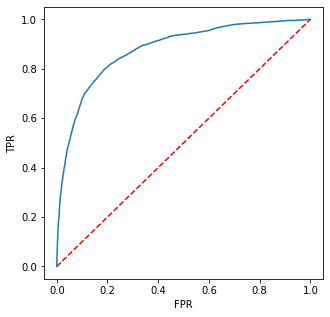

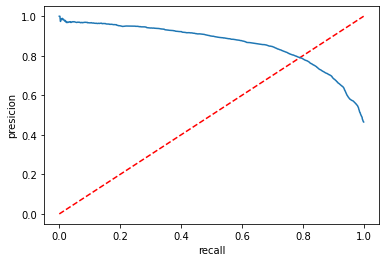

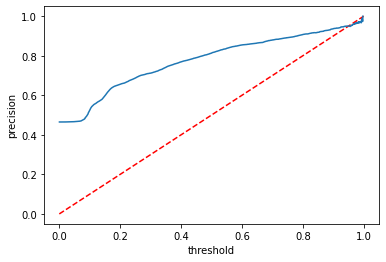

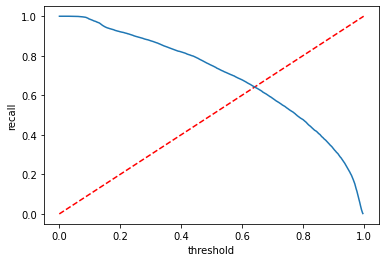

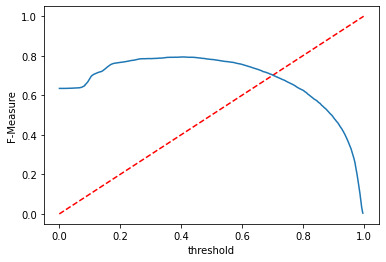

In [0]:
plt.figure(figsize=(5,5))
# roc 
#plt.subplot(2, 6, 1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(training_result.roc.select('FPR').collect(),
         training_result.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#plt.subplot(2, 6, 2)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(training_result.pr.select('recall').collect(),
         training_result.pr.select('precision').collect())
plt.xlabel('recall')
plt.ylabel('presicion')
plt.show()

#plt.subplot(2, 6, 3)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(training_result.precisionByThreshold.select('threshold').collect(),
         training_result.precisionByThreshold.select('precision').collect())
plt.xlabel('threshold')
plt.ylabel('precision')
plt.show()


#plt.subplot(2, 6, 4)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(training_result.recallByThreshold.select('threshold').collect(),
         training_result.recallByThreshold.select('recall').collect())
plt.xlabel('threshold')
plt.ylabel('recall')
plt.show()

#plt.subplot(2, 6, 5)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(training_result.fMeasureByThreshold.select('threshold').collect(),
         training_result.fMeasureByThreshold.select('F-Measure').collect())
plt.xlabel('threshold')
plt.ylabel('F-Measure')


plt.show()

## Desicion Tree

In [0]:
# This function defines the general pipeline for logistic regression
def decision_tree_pipeline(train, 
                           numerical_features, 
                           categorical_features, 
                           target_variable, 
                           with_std=True,
                           with_mean=True,
                           k_fold=5):

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # Indexing the target column (i.e., transform human/bot into 1/0) and rename it as "label"
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numerical_features, outputCol="features")

    # Populate the stages of the pipeline with all the preprocessing steps
    stages = indexers + [label_indexer] + [assembler] # + ...

    # Create the decision tree transformer
    dt = DecisionTreeClassifier(featuresCol="features", labelCol="label") # change `featuresCol=std_features` if scaler is used

    # 5. Add the decision tree transformer to the pipeline stages (i.e., the last one)
    stages += [dt]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for dt.maxDepth and 2 values for dt.impurity
    # this grid will have 3 x 2 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [3, 5, 8]) \
    .addGrid(dt.impurity, ["gini", "entropy"]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

### Training Set

In [0]:
cv_model = decision_tree_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
# This function summarizes all the models trained during k-fold cross validation
def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: maxDept=[{:d}]; impurity=[{:s}] ".format(m.stages[-1]._java_obj.getMaxDepth(), m.stages[-1]._java_obj.getImpurity()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [0]:
summarize_all_models(cv_model.subModels)

*************** Fold #1 ***************

--- Model #1 out of 6 ---
	Parameters: maxDept=[3]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=3, numNodes=7, numClasses=2, numFeatures=14

--- Model #2 out of 6 ---
	Parameters: maxDept=[3]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=3, numNodes=7, numClasses=2, numFeatures=14

--- Model #3 out of 6 ---
	Parameters: maxDept=[5]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=5, numNodes=33, numClasses=2, numFeatures=14

--- Model #4 out of 6 ---
	Parameters: maxDept=[5]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=5, numNodes=29, numClasses=2, numFeatures=14

--- Model #5 out of 6 ---
	Parameters: maxDept=[8]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=8, numNodes=289, numClasses=2, numFeatures=14

--- Model #6 out of 6 ---
	Parameters: maxDept=[8]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=8, numNodes=249, numClasses=2, numFeatures=14

***************************************

*************** Fold #2 ***************

--- Model #1 out of 6 ---
	Parameters: maxDept=[3]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=3, numNodes=9, numClasses=2, numFeatures=14

--- Model #2 out of 6 ---
	Parameters: maxDept=[3]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=3, numNodes=9, numClasses=2, numFeatures=14

--- Model #3 out of 6 ---
	Parameters: maxDept=[5]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=5, numNodes=43, numClasses=2, numFeatures=14

--- Model #4 out of 6 ---
	Parameters: maxDept=[5]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=5, numNodes=31, numClasses=2, numFeatures=14

--- Model #5 out of 6 ---
	Parameters: maxDept=[8]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=8, numNodes=299, numClasses=2, numFeatures=14

--- Model #6 out of 6 ---
	Parameters: maxDept=[8]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=8, numNodes=277, numClasses=2, numFeatures=14

***************************************

*************** Fold #3 ***************

--- Model #1 out of 6 ---
	Parameters: maxDept=[3]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=3, numNodes=7, numClasses=2, numFeatures=14

--- Model #2 out of 6 ---
	Parameters: maxDept=[3]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=3, numNodes=7, numClasses=2, numFeatures=14

--- Model #3 out of 6 ---
	Parameters: maxDept=[5]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=5, numNodes=41, numClasses=2, numFeatures=14

--- Model #4 out of 6 ---
	Parameters: maxDept=[5]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=5, numNodes=31, numClasses=2, numFeatures=14

--- Model #5 out of 6 ---
	Parameters: maxDept=[8]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=8, numNodes=321, numClasses=2, numFeatures=14

--- Model #6 out of 6 ---
	Parameters: maxDept=[8]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=8, numNodes=273, 

In [0]:
training_result = 0
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))
    if training_result < avg_roc_auc:
      training_result = avg_roc_auc

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.822
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.828
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.870
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.858
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.870
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.881

In [0]:
print("Best model according to k-fold cross validation: maxDept=[{:d}]; impurity=[{:s}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getMaxDepth(), 
             cv_model.bestModel.stages[-1]._java_obj.getImpurity(),
             )
      )
print(cv_model.bestModel.stages[-1])

Best model according to k-fold cross validation: maxDept=[8]; impurity=[entropy]
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b02126fd792c, depth=8, numNodes=261, numClasses=2, numFeatures=14

In [0]:
predictions_train = cv_model.transform(train_df)
predictions_train.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(14,[3,4,8,10,12,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
+--------------------+----------+-----+
only showing top 5 rows

### Test Set

In [0]:
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_predictions = cv_model.transform(test_df)
test_predictions.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(14,[3,4,8,9,10,1...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
+--------------------+----------+-----+
only showing top 5 rows

### Evaluation

In [0]:
print("***** Training Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(training_result))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(predictions_train, metric="areaUnderPR")))

print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))

***** Training Set *****
Area Under ROC Curve (ROC AUC): 0.881
Area Under Precision-Recall Curve: 0.843
***** Test Set *****
Area Under ROC Curve (ROC AUC): 0.898
Area Under Precision-Recall Curve: 0.840

## Random Forests

In [0]:
# This function defines the general pipeline for logistic regression
def random_forest_pipeline(train, 
                           numerical_features, 
                           categorical_features, 
                           target_variable, 
                           with_std=True,
                           with_mean=True,
                           k_fold=5):


    # Configure a random forest pipeline, which consists of the following stages: 

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # Indexing the target column (i.e., transform human/bot into 1/0) and rename it as "label"
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numerical_features, outputCol="features")

    # Populate the stages of the pipeline with all the preprocessing steps
    stages = indexers + [label_indexer] + [assembler] # + ...

    # Create the random forest transformer
    rf = RandomForestClassifier(featuresCol="features", labelCol="label") # change `featuresCol=std_features` if scaler is used

    # 5. Add the random forest transformer to the pipeline stages (i.e., the last one)
    stages += [rf]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for rf.maxDepth and 3 values for rf.numTrees
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [3, 5, 8]) \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .build()
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model


### Training Set

In [0]:
cv_model = random_forest_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
training_result = 0
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))
    if avg_roc_auc > training_result:
      training_result = avg_roc_auc

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.908
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.914
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.915
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.927
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.930
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.932
Avg. ROC AUC computed across k-fold cross validation for model setting #7: 0.943
Avg. ROC AUC computed across k-fold cross validation for model setting #8: 0.946
Avg. ROC AUC computed across k-fold cross validation for model setting #9: 0.947

In [0]:
print("Best model according to k-fold cross validation: maxDept=[{:d}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getMaxDepth(),),)

print(cv_model.bestModel.stages[-1])

Best model according to k-fold cross validation: maxDept=[8]
RandomForestClassificationModel: uid=RandomForestClassifier_566db9e4ffe8, numTrees=100, numClasses=2, numFeatures=14

In [0]:
predictions_train = cv_model.transform(train_df)
predictions_train.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(14,[3,4,8,10,12,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
+--------------------+----------+-----+
only showing top 5 rows

### Test Set

In [0]:
#training_result = cv_model.bestModel.stages[-1].summary
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_predictions = cv_model.transform(test_df)
test_predictions.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(14,[3,4,8,9,10,1...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
+--------------------+----------+-----+
only showing top 5 rows

### Evaluation

In [0]:
print("***** Training Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(training_result))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(predictions_train, metric="areaUnderPR")))

print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))

***** Training Set *****
Area Under ROC Curve (ROC AUC): 0.947
Area Under Precision-Recall Curve: 0.948
***** Test Set *****
Area Under ROC Curve (ROC AUC): 0.948
Area Under Precision-Recall Curve: 0.934

## Factorization Machines

In [0]:
def fm_pipeline(train, 
                numerical_features,
                categorical_features, 
                target_variable, 
                with_std=True,
                with_mean=True,
                k_fold=5):



    # 1.a Create a list of indexers, i.e., one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # 1.b Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")


    # Indexing the target column (i.e., transform human/bot into 1/0) and rename it as "label"
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numerical_features, outputCol="features")

    featureScaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
    
    stages = indexers + [encoder] + [label_indexer] + [assembler] + [featureScaler]
    
    fm = FMClassifier(labelCol="label", featuresCol="scaledFeatures")

    # 5. Add the decision tree transformer to the pipeline stages (i.e., the last one)
    stages += [fm]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(fm.stepSize, [0.001,0.002,0.005,0.01]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

### Training Set

In [0]:
cv_model = fm_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
training_result = 0
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))
    if avg_roc_auc > training_result:
      training_result = avg_roc_auc

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.838
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.854
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.875
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.881

In [0]:
predictions_train = cv_model.transform(train_df)
predictions_train.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(14,[3,4,8,10,12,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
+--------------------+----------+-----+
only showing top 5 rows

### Test Set

In [0]:
#training_result = cv_model.bestModel.stages[-1].summary
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_predictions = cv_model.transform(test_df)
test_predictions.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(14,[3,4,8,9,10,1...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
(14,[3,8,9,10,11,...| 0.0| 0.0|
+--------------------+----------+-----+
only showing top 5 rows

### Evaluation

In [0]:
print("***** Training Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(training_result))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(predictions_train, metric="areaUnderPR")))


print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))

***** Training Set *****
Area Under ROC Curve (ROC AUC): 0.881
Area Under Precision-Recall Curve: 0.866
***** Test Set *****
Area Under ROC Curve (ROC AUC): 0.894
Area Under Precision-Recall Curve: 0.881

## Classification on textual data

### Clean text

In [0]:
def clean_text(text):

  if text is None:
    return ""
  if text == []:
    return ""
  row = text.lower()
  row = row.strip() 
  row = re.sub(r'[^\w\s]',' ',row)
  row = re.sub(r'\_',' ',row)

  filtered_sentence = ""
  for w in row.split() :
    temp = lancaster.stem(w)
    filtered_sentence += (temp + " ")
  row = filtered_sentence

  if row is None:
    return ""
  if row == []:
    return ""
  return row
clean_udf = spark.udf.register("clean_text",clean_text)

### Train-Test Split

In [0]:
bot_df_text = bot_df_text.select(clean_udf(col("tweet_text")) , clean_udf(col("description")),"account_type")
tweet_train_df, tweet_test_df = bot_df_text.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

# Rename columns
tweet_train_df = tweet_train_df.withColumnRenamed("clean_text(tweet_text)", "tweet_text")\
       .withColumnRenamed("clean_text(description)", "description")
tweet_test_df = tweet_test_df.withColumnRenamed("clean_text(tweet_text)", "tweet_text")\
       .withColumnRenamed("clean_text(description)", "description")

# Drop empty rows
tweet_train_df = tweet_train_df.na.drop()
tweet_test_df = tweet_test_df.na.drop()

In [0]:
tweet_train_df.show(10)

## Logistic Regression

In [0]:
# This function defines the general pipeline for logistic regression
def logistic_regression_pipeline(train, 
                                 target_variable, 
                                 with_std=True,
                                 with_mean=True,
                                 k_fold=5):

    # Configure a logistic regression pipeline, which consists of the following stages: 
    stage_1 = RegexTokenizer(inputCol="tweet_text", outputCol="tokens", pattern="\\W")
    # define stage 2: remove the stop words
    stage_2 = StopWordsRemover(inputCol="tokens", outputCol="filtered_words")
    # define stage 3: create a word vector of the size 100
    stage_3 = Word2Vec(inputCol="filtered_words", outputCol="feature_vector", vectorSize=100)

    # define stage 4: tokenize the description
    stage_4 = RegexTokenizer(inputCol="description", outputCol="tokens_des", pattern="\\W")
    # define stage 2: remove the stop words
    stage_5 = StopWordsRemover(inputCol="tokens_des", outputCol="filtered_words_des")
    # define stage 3: create a word vector of the size 100
    stage_6 = Word2Vec(inputCol="filtered_words_des", outputCol="feature_vector_des", vectorSize=100)
   

    # 1.c Indexing the target column (i.e., transform human/bot into 1/0) and rename it as "label"
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # 1.d Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=["feature_vector_des" , "feature_vector"] , outputCol="features") #"feature_vector",

    # 2.a Create the StandardScaler
    # scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=with_std, withMean=with_mean)
    # ...

    # 3 Populate the stages of the pipeline with all the preprocessing steps
    stages = [stage_1] + [stage_2] + [stage_3] + [stage_4] + [stage_5] + [stage_6] + [label_indexer] + [assembler]  # + [scaler] + ...  

    # 4. Create the logistic regression transformer
    #log_reg = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100) # change `featuresCol=std_features` if scaler is used
    # 5. Add the logistic regression transformer to the pipeline stages (i.e., the last one)
    #stages += [log_reg]

    # 4. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    transformer = pipeline.fit(train)
    df_transformed = transformer.transform(train)

    # 5. Eventually, return both the transformed dataframe and the transformer object for future transformations
    return transformer, df_transformed

### Training Set

In [0]:
oh_transformer, oh_train_df = logistic_regression_pipeline(tweet_train_df, TARGET_VARIABLE)

In [0]:
train = oh_train_df.select(["features", "label"])
train.show(10)

In [0]:
log_reg = LogisticRegression(featuresCol = "features", labelCol = "label", maxIter=100)
log_reg_model = log_reg.fit(train)
training_summary = log_reg_model.summary

In [0]:
predictions_train = log_reg_model.transform(train)
predictions_train.select("features", "prediction", "label").show(5)

### Test Set

In [0]:
oh_test_df = oh_transformer.transform(tweet_test_df)
test = oh_test_df.select(["features", "label"])
test.show(10)

In [0]:
predictions = log_reg_model.transform(test)
predictions.select("features", "prediction", "label").show(5)

### Evaluation

In [0]:
print("***** Training Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(training_summary.areaUnderROC))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(predictions_train, metric="areaUnderPR")))

print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(predictions, metric="areaUnderPR")))

## Decision Tree

### Training Set

In [0]:
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dt_model = dt.fit(train)

In [0]:
predictions_train = dt_model.transform(train)
predictions_train.select("features", "prediction", "label").show(5)

### Test Set

In [0]:
predictions = dt_model.transform(test)
predictions.select("features", "prediction", "label").show(5)

### Evaluation

In [0]:
print("***** Training Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(predictions_train)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(predictions, metric="areaUnderPR")))

print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(predictions, metric="areaUnderPR")))

## Random Forests

### Training Set

In [0]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
rf_model = rf.fit(train)

In [0]:
predictions_train = rf_model.transform(train)
predictions_train.select("features", "prediction", "label").show(5)

### Test Set

In [0]:
predictions = rf_model.transform(test)
predictions.select("features", "prediction", "label").show(5)

### Evaluation

In [0]:
print("***** Training Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(predictions_train)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(predictions_train, metric="areaUnderPR")))      
  
print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(predictions, metric="areaUnderPR")))

## Factorization Machines

### Training Set

In [0]:
fm = FMClassifier(labelCol="label", featuresCol="features")
fm_model = fm.fit(train)

In [0]:
predictions_train = fm_model.transform(train)
predictions_train.select("features", "prediction", "label").show(5)

### Test Set

In [0]:
predictions = fm_model.transform(test)
predictions.select("features", "prediction", "label").show(5)

### Evaluation

In [0]:
print("***** Training Set *****")
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(predictions_train)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(predictions_train, metric="areaUnderPR")))
  
print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(predictions, metric="areaUnderPR")))

## Our website's front-end

In [0]:
s = """<!DOCTYPE html>
<html>
	<head>
		<title>Bot Detector Website</title>
        <link rel= "stylesheet" type= "text/css" href= "{{ url_for('static',filename='styles/index.css') }}">
	</head>
	<body>
        <div class="container">
            <h1>Twitter Bot Detector</h1> 
            <p>Check if a user is human or bot.</p>
            <form action="" method="post">
                <input type="text" placeholder="e.g. @hello_kitty123" name="name">
                <div class="bar"></div>
                <div class="highlight"></div>
                <button class="btn striped-shadow dark" type="submit" value="submit"><span>Check</span></button>
            </form>

        </div>
	</body>
    
    <style>
body {
  font-family: courier, arial, helvetica;
  font-size: 150%;
  color: #77bfa1;
  background-color: #726da8;
}

.container {
  text-align: center;
  margin-top: 10%;
  font-weight: bold;
}

@import "https://fonts.googleapis.com/css?family=Bungee+Shade";

*,
:after,
:before {
  box-sizing: border-box;
}

:focus {
  outline: none;
}

button {
  overflow: visible;
  border: 0;
  padding: 0;
  margin: 1.8rem;
}
.btn.striped-shadow span {
  display: block;
  position: relative;
  z-index: 2;
  border: 5px solid;
}

.btn.striped-shadow.dark span {
  border-color: #393939;
  background: #77bfa1;
  color: #393939;
}

.btn {
  height: 80px;
  line-height: 65px;
  display: inline-block;
  letter-spacing: 1px;
  position: relative;
  font-size: 1.35rem;
  transition: opacity 0.3s, z-index 0.3s step-end, -webkit-transform 0.3s;
  transition: opacity 0.3s, z-index 0.3s step-end, transform 0.3s;
  transition: opacity 0.3s, z-index 0.3s step-end, transform 0.3s,
    -webkit-transform 0.3s;
  z-index: 1;
  background-color: transparent;
  cursor: pointer;
}

.btn {
  width: 155px;
  height: 48px;
  line-height: 38px;
}

button.btn.striped-shadow.dark:after,
button.btn.striped-shadow.dark:before {
  background-image: linear-gradient(
    135deg,
    transparent 0,
    transparent 5px,
    #393939 5px,
    #393939 10px,
    transparent 10px
  );
}

button.btn.striped-shadow:hover:before {
  max-height: calc(100% - 10px);
}

button.btn.striped-shadow:after {
  width: calc(100% - 4px);
  height: 8px;
  left: -10px;
  bottom: -9px;
  background-size: 15px 8px;
  background-repeat: repeat-x;
}
button.btn.striped-shadow:after,
button.btn.striped-shadow:before {
  content: "";
  display: block;
  position: absolute;
  z-index: 1;
  transition: max-height 0.3s, width 0.3s, -webkit-transform 0.3s;
  transition: transform 0.3s, max-height 0.3s, width 0.3s;
  transition: transform 0.3s, max-height 0.3s, width 0.3s,
    -webkit-transform 0.3s;
}

.btn.striped-shadow:hover {
  -webkit-transform: translate(-12px, 12px);
  -ms-transform: translate(-12px, 12px);
  transform: translate(-12px, 12px);
  z-index: 3;
}

button.btn.striped-shadow:hover:after,
button.btn.striped-shadow:hover:before {
  -webkit-transform: translate(12px, -12px);
  -ms-transform: translate(12px, -12px);
  transform: translate(12px, -12px);
}
button.btn.striped-shadow:before {
  width: 8px;
  max-height: calc(100% - 5px);
  height: 100%;
  left: -12px;
  bottom: -5px;
  background-size: 8px 15px;
  background-repeat: repeat-y;
  background-position: 0 100%;
}

.input {
  margin: 5% 10%;
  position: relative;
  width: fit-content;
}
input {
  padding: 10px 10px 10px 5px;
  font-size: 18px;
  width: 280px;
  border: 1px solid;
  border-color: transparent transparent gray;
  background-color: transparent;
}
input:focus {
  outline: none;
}
/*Label */
label {
  position: absolute;
  top: 30%;
  font-size: 18px;
  color: rgb(165, 165, 165);
  left: 3%;
  z-index: -1;
  pointer-events: none;
  transition: all 0.3s;
  -webkit-transition: all 0.3s;
  -moz-transition: all 0.3s;
  -ms-transition: all 0.3s;
  -o-transition: all 0.3s;
}
/* Activate State */
input:focus + label,
input:valid + label {
  font-size: 12px;
  color: rgb(148, 98, 255);
  top: -1%;
  transition: all 0.3s;
  -webkit-transition: all 0.3s;
  -moz-transition: all 0.3s;
  -ms-transition: all 0.3s;
  -o-transition: all 0.3s;
}
/*End Label */
/*Bar*/
.bar {
  width: 100%;
  height: 2px;
  position: absolute;
  background-color: rgb(148, 98, 255);
  top: calc(100% - 2px);
  left: 0;
  transform: scaleX(0);
  -webkit-transform: scaleX(0);
  -moz-transform: scaleX(0);
  -ms-transform: scaleX(0);
  -o-transform: scaleX(0);
}
/*Activate State */
input:focus ~ .bar,
input:valid ~ .bar {
  transform: scaleX(1);
  -webkit-transform: scaleX(1);
  -moz-transform: scaleX(1);
  -ms-transform: scaleX(1);
  -o-transform: scaleX(1);
  transition: transform 0.3s;
  -webkit-transition: transform 0.3s;
  -moz-transition: transform 0.3s;
  -ms-transition: transform 0.3s;
  -o-transition: transform 0.3s;
}
/*End Bar */
/*Highlight */
.highlight {
  width: 100%;
  height: 85%;
  position: absolute;
  background-color: rgba(148, 98, 255, 0.2);
  top: 15%;
  left: 0;
  visibility: hidden;
  z-index: -1;
}
input:focus ~ .highlight {
  width: 0;
  visibility: visible;
  transition: all 0.09s linear;
  -webkit-transition: all 0.09s linear;
  -moz-transition: all 0.09s linear;
  -ms-transition: all 0.09s linear;
  -o-transition: all 0.09s linear;
}
/*End highlight */
::placeholder {
  color: #77bfa1;
  font-size: 20px;
}
</style>

</html>"""
h = HTML(s)
display(h)